In [1]:
import plotly.express as px
import pandas as pd

data = pd.read_csv('C:\\Users\\HP\\Documents\\TPexam\\Cleaned_ds_salaries.csv')
data['work_year'] = pd.to_datetime(data['work_year'])

In [2]:
data.columns

Index(['work_year', 'experience_level', 'employment_type', 'job_title',
       'salary', 'salary_currency', 'salary_in_usd', 'employee_residence',
       'remote_ratio', 'company_location', 'company_size',
       'Cumulative_Savings10%_of_their_salary_annually'],
      dtype='object')

In [3]:
# data info
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1943 entries, 0 to 1942
Data columns (total 12 columns):
 #   Column                                          Non-Null Count  Dtype         
---  ------                                          --------------  -----         
 0   work_year                                       1943 non-null   datetime64[ns]
 1   experience_level                                1943 non-null   object        
 2   employment_type                                 1943 non-null   object        
 3   job_title                                       1943 non-null   object        
 4   salary                                          1943 non-null   int64         
 5   salary_currency                                 1943 non-null   object        
 6   salary_in_usd                                   1943 non-null   int64         
 7   employee_residence                              1943 non-null   object        
 8   remote_ratio                                    

In [4]:
data.shape

(1943, 12)

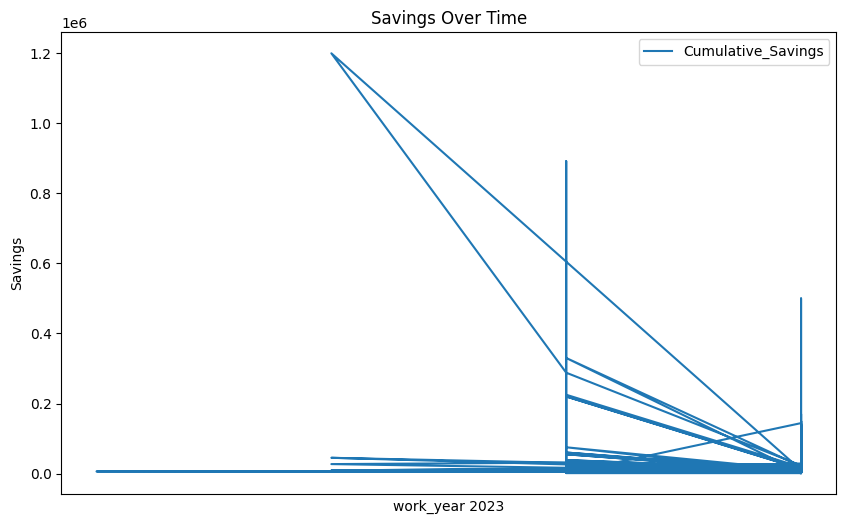

In [6]:
import matplotlib.pyplot as plt

# Plot Savings over time
plt.figure(figsize=(10,6))
plt.plot(data['work_year'], data['Cumulative_Savings10%_of_their_salary_annually'], label='Cumulative_Savings')
plt.xlabel('work_year 2023')
plt.ylabel('Savings')
plt.title('Savings Over Time')
plt.legend()
plt.show()

Checking for stationarity: using Dickey-Fuller Test (ADF Test) and Rolling Statistics.<br>
The Augmented Dickey-Fuller (ADF) test is a statistical test used to check for stationarity.<br>
A low p-value (< 0.05) indicates that the time series is stationary.<br>

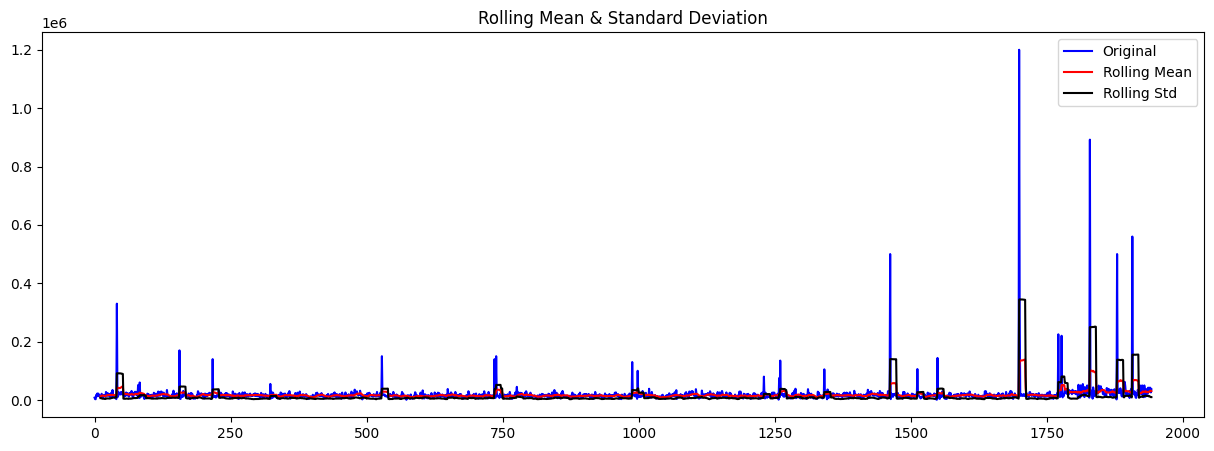

Results of Dickey-Fuller Test:
Test Statistic                  -40.012168
p-value                           0.000000
#Lags Used                        0.000000
Number of Observations Used    1942.000000
Critical Value (1%)              -3.433722
Critical Value (5%)              -2.863029
Critical Value (10%)             -2.567563
dtype: float64


In [8]:
from statsmodels.tsa.stattools import adfuller

def test_stationarity(timeseries):
    #Determing rolling statistics
    MA = timeseries.rolling(window=12).mean()
    MSTD = timeseries.rolling(window=12).std()

    #Plot rolling statistics:
    plt.figure(figsize=(15,5))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(MA, color='red', label='Rolling Mean')
    std = plt.plot(MSTD, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
    
test_stationarity(data['Cumulative_Savings10%_of_their_salary_annually'])

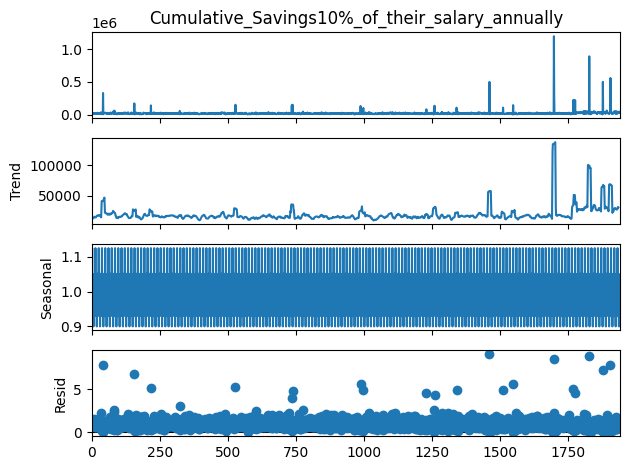

In [9]:
from itertools import combinations
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima_model import ARIMA as ARIMA
import statsmodels.api as sm
import statsmodels.tsa.api as smt
dec = sm.tsa.seasonal_decompose(data['Cumulative_Savings10%_of_their_salary_annually'],period = 12, model = 'multiplicative').plot()
plt.show()

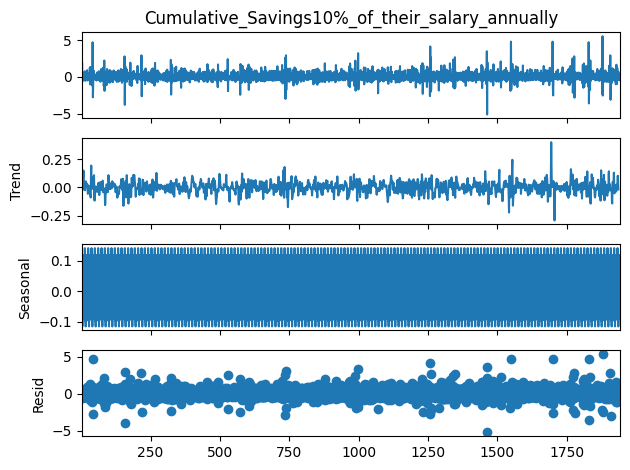

In [14]:
import numpy as np


savings_data = data['Cumulative_Savings10%_of_their_salary_annually']  

# Log transform the numeric data
data_log = np.log(savings_data)

# Perform differencing to remove trend and seasonality (first-order differencing)
data_log_diff = data_log.diff().dropna()

dec = sm.tsa.seasonal_decompose(data_log_diff,period = 12).plot()
plt.show()


## Modelling: Find the autoregressive and moving-average orders by plotting the autocorrelation and partial autocorrelation functions

In [11]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf

def tsplot(y, lags=None, figsize=(12, 7), style='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
        
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        
        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()
       

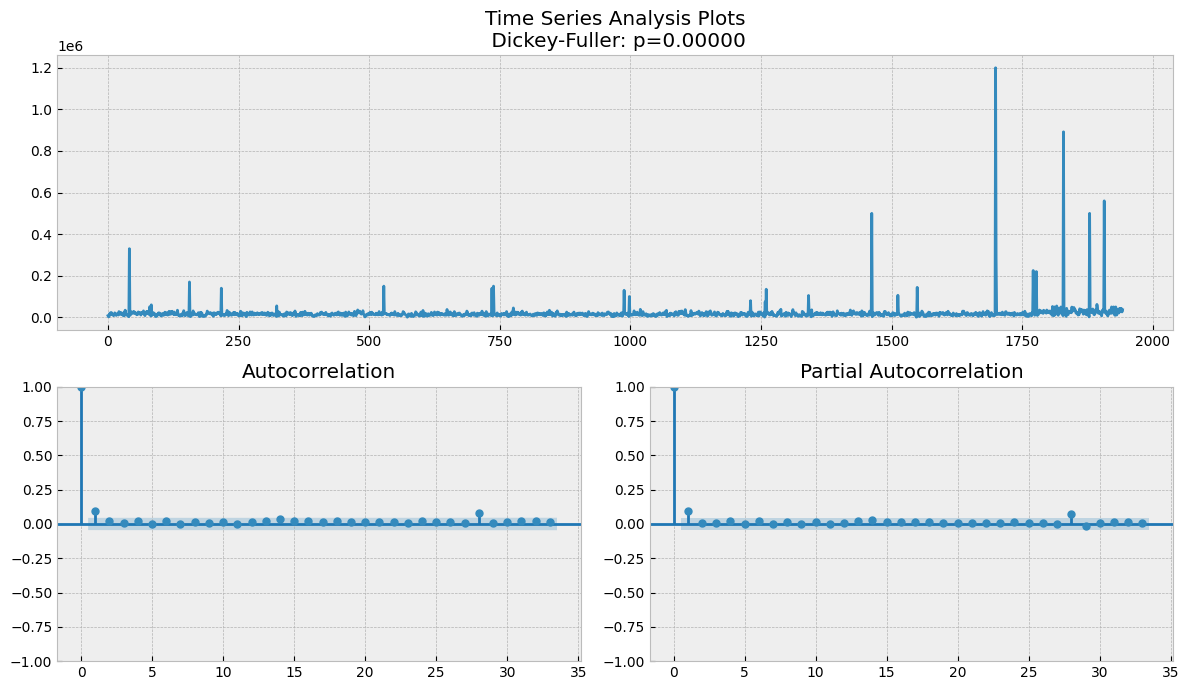

In [12]:
#Data before differencing
tsplot(data['Cumulative_Savings10%_of_their_salary_annually'])

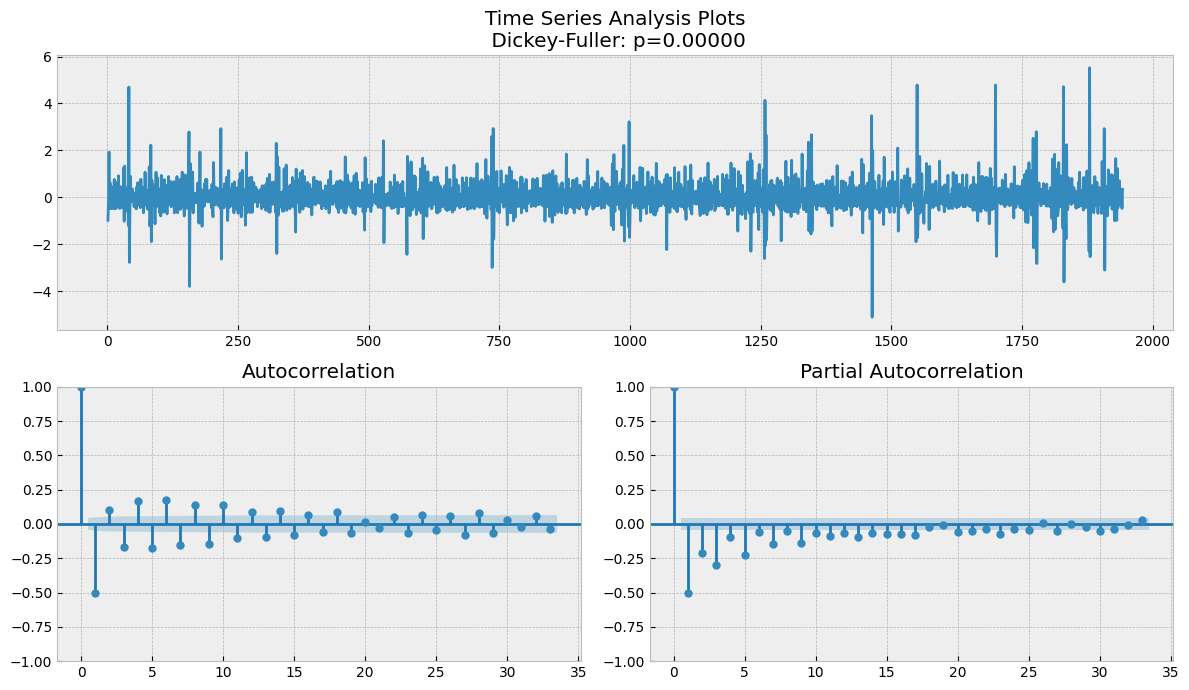

In [15]:
#Data after differencing
tsplot(data_log_diff)

### The blue region above in the autocorrelation and partial autocorrelation signifies where the points are no longer statistically significant and from the plot we see the last lag that is statistically significant for both plot is 1. Therefore, we would take the order of p and q to be 1.

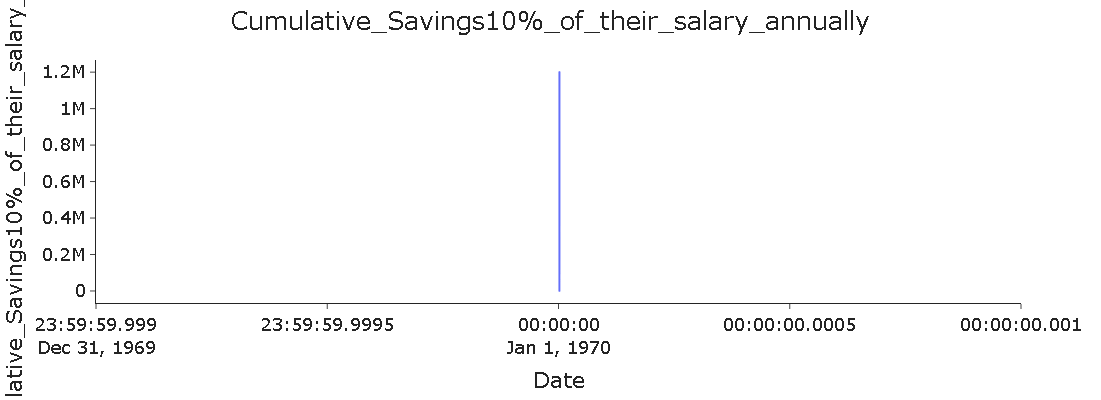

In [21]:
def plot_savings_volumes(df: pd.DataFrame,
                           y: str) -> None:
    """General function to plot the  data."""

    fig = px.line(df, x='work_year', y=y, labels={'work_year': 'Date'})
    fig.update_layout(template="simple_white", font=dict(size=18), title_text='Cumulative_Savings',
                      width=650, title_x=0.5, height=400)

    return fig.show()

# Plotting the data
plot_savings_volumes(df=data, y='Cumulative_Savings10%_of_their_salary_annually')

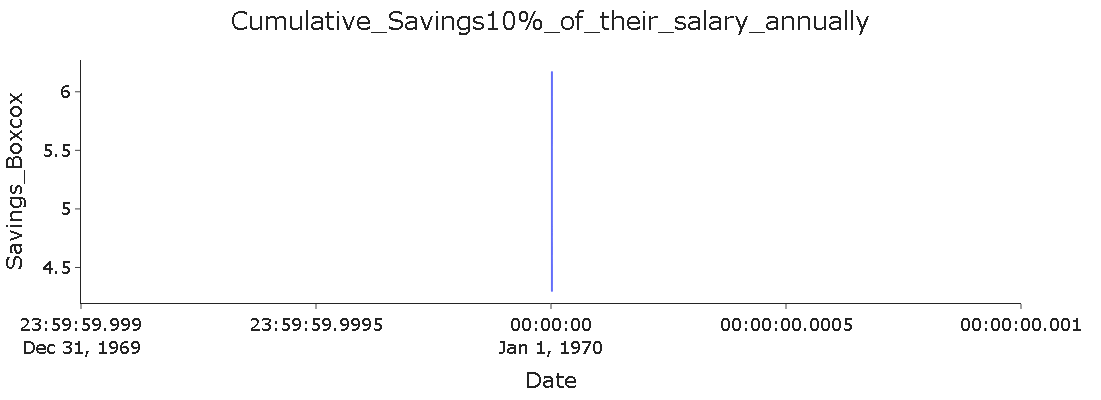

In [22]:
# Import packages 
from scipy.stats import boxcox
data['Cumulative_Savings10%_of_their_salary_annually'] = data['Cumulative_Savings10%_of_their_salary_annually'].apply(lambda x: x if x > 0 else x + 1)

# Make the target variance stationary
data['Savings_Boxcox'], lam = boxcox(data['Cumulative_Savings10%_of_their_salary_annually'])

# Plot the box-cox data
plot_savings_volumes(df=data, y='Savings_Boxcox')

## Fitting the model using the ARIMA function and generate the forecasts:

In [23]:
from statsmodels.tsa.arima.model import ARIMA
from scipy.special import inv_boxcox

# Split train and test
train = data.iloc[:-int(len(data) * 0.2)]
test = data.iloc[-int(len(data) * 0.2):]

# Building ARIMA model and inverse the boxcox
model = ARIMA(train['Savings_Boxcox'], order=(12, 1, 12)).fit()
boxcox_forecasts = model.forecast(len(test))
forecasts = inv_boxcox(boxcox_forecasts, lam)

C:\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



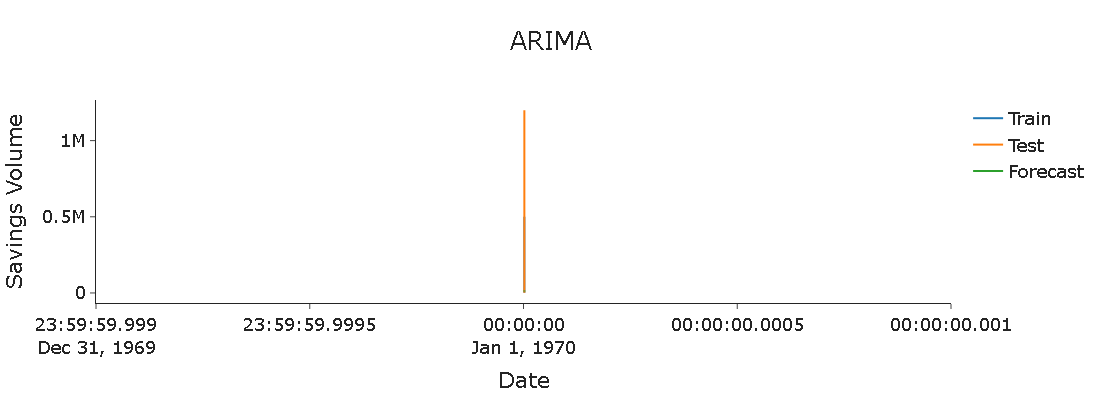

In [24]:
import plotly.graph_objects as go

def plot_forecasts(forecasts: list[float], title: str) -> None:
    """Function to plot the forecasts."""
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=train['work_year'], y=train['Cumulative_Savings10%_of_their_salary_annually'], name='Train'))
    fig.add_trace(go.Scatter(x=test['work_year'], y=test['Cumulative_Savings10%_of_their_salary_annually'], name='Test'))
    fig.add_trace(go.Scatter(x=test['work_year'], y=forecasts, name='Forecast'))
    fig.update_layout(template="simple_white", font=dict(size=18), title_text=title,
                      width=650, title_x=0.5, height=400, xaxis_title='Date',
                      yaxis_title='Savings Volume')

    return fig.show()
# Plot the forecasts
plot_forecasts(forecasts, 'ARIMA')